# Principal Component Analysis

## Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import cartopy.crs as ccrs
from eofs.xarray import Eof
import regionmask
import scipy.signal as sig
from scipy.stats import pearsonr
import itertools

## Data

In [2]:
nemo00_sst_monthly_2011_2022 = xr.open_dataarray('../data/processed/nemo00_sst_monthly_2011_2022.nc')
observations_sst_monthly_2011_2022 = xr.open_dataarray('../data/processed/observations_sst_monthly_2011_2022.nc')
mesh = xr.open_dataset('../data/model/orca05l75_domain_cfg_nemov5_10m.nc')

## Calculations

In [3]:
NbrPC = 20

### Observations

In [4]:
# Select Northern Pacific
sst_obs_region = observations_sst_monthly_2011_2022.sel(lat=slice(60,-20), lon=slice(117,260))

# Compute monthly climatology and anomalies
clim_obs = sst_obs_region.groupby('time.month').mean('time')
anoms_obs = sst_obs_region.groupby('time.month') - clim_obs

# Detrend
anoms_obs_np = anoms_obs.fillna(0).values  # shape (time, lat, lon)
anoms_obs_detrended = sig.detrend(anoms_obs_np, axis=0)

# Convert back to DataArray
anoms_obs_detrended_xr = xr.DataArray(
    anoms_obs_detrended,
    dims=anoms_obs.dims,
    coords=anoms_obs.coords,
    name='sst_anoms_detrended'
)

# Calculate weights based on cosine latitude
lat_rad = np.deg2rad(anoms_obs_detrended_xr['lat'])
weights_1d = np.sqrt(np.cos(lat_rad))
weights_1d /= weights_1d.sum()
weights_2d, _ = xr.broadcast(weights_1d, anoms_obs_detrended_xr['lon'])
weights = weights_2d.where(sst_obs_region.notnull().isel(time=0))

# Compute EOFs
solver_obs = Eof(anoms_obs_detrended_xr, weights=weights)
eofvar_obs = solver_obs.varianceFraction(neigs=NbrPC) * 100
covmaps_obs = solver_obs.eofsAsCovariance(neofs=NbrPC)
pcs_obs = solver_obs.pcs(pcscaling=1, npcs=NbrPC)

### Model

In [5]:
# Select Northern Pacific
sst_model_region = nemo00_sst_monthly_2011_2022.sel(lat=slice(60, -20), lon=slice(117, 260))

# Compute monthly climatology and anomalies
clim_model = sst_model_region.groupby('time.month').mean('time')
anoms_model = sst_model_region.groupby('time.month') - clim_model

# Detrend
anoms_model_np = anoms_model.fillna(0).values
anoms_model_detrended = sig.detrend(anoms_model_np, axis=0)

# Convert back to DataArray
anoms_model_detrended_xr = xr.DataArray(
    anoms_model_detrended,
    dims=anoms_model.dims,
    coords=anoms_model.coords,
    name='sst_model_anoms_detrended'
)

# Compute EOFs with same weights
solver_model = Eof(anoms_model_detrended_xr, weights=weights)
eofvar_model = solver_model.varianceFraction(neigs=NbrPC) * 100
covmaps_model = solver_model.eofsAsCovariance(neofs=NbrPC)
pcs_model = solver_model.pcs(pcscaling=1, npcs=NbrPC)

### Align phases (signs)

In [6]:
# Align EOF signs by correlation of PCs
for mode in range(NbrPC):
    corr = np.corrcoef(pcs_obs.sel(mode=mode), pcs_model.sel(mode=mode))[0, 1]
    if corr < 0:
        covmaps_model[mode] *= -1
        pcs_model[:, mode] *= -1

### Error

In [7]:
eofvar_error = eofvar_model - eofvar_obs
covmaps_error = covmaps_model - covmaps_obs
pcs_error = pcs_model - pcs_obs

## Comparison

In [8]:
NbrPC_plot = 4

# Base colors per PC (mode)
base_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
               'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
pc_colors = list(itertools.islice(itertools.cycle(base_colors), NbrPC))

linestyles = {
    'Obs': '-',
    'Model': '--',
    'Error': ':'
}

### Explained variance

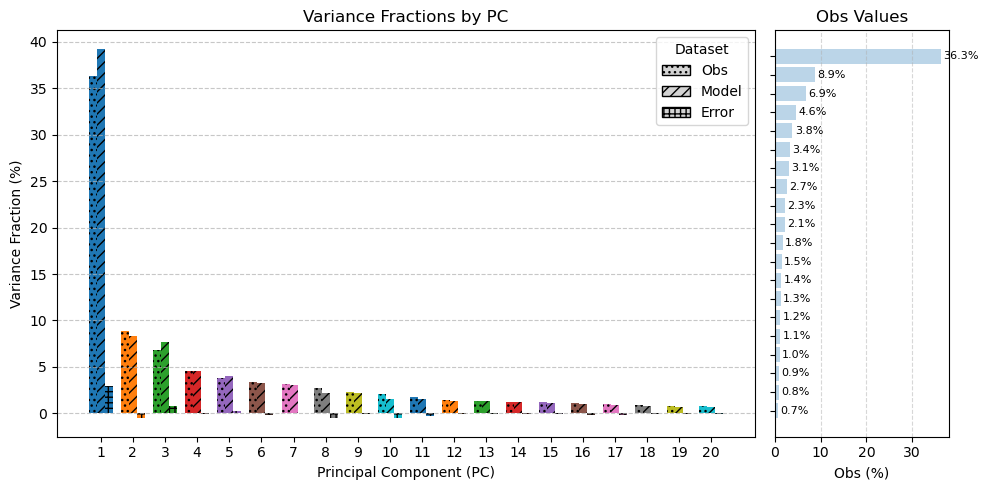

In [9]:


















# Parameters
width = 0.25
x = np.arange(NbrPC)

# Hatches to differentiate dataset types
dataset_hatches = {
    'Obs': '...',
    'Model': '///',
    'Error': '+++'
}

# Create a figure with two subplots (main bars and value bar)
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])
ax = fig.add_subplot(gs[0])
ax_val = fig.add_subplot(gs[1])

# Main bar plot
bars_obs = []
bars_model = []
bars_error = []

for i in range(NbrPC):
    bars_obs.append(ax.bar(x[i] - width, eofvar_obs.values[i], width,
                           color=pc_colors[i], hatch=dataset_hatches['Obs']))
    bars_model.append(ax.bar(x[i], eofvar_model.values[i], width,
                             color=pc_colors[i], hatch=dataset_hatches['Model']))
    bars_error.append(ax.bar(x[i] + width, eofvar_error.values[i], width,
                             color=pc_colors[i], hatch=dataset_hatches['Error']))

# Format main axis
ax.set_xticks(x)
ax.set_xlabel('Principal Component (PC)')
ax.set_xticklabels([f'{i+1}' for i in x])
ax.set_ylabel('Variance Fraction (%)')
ax.set_title('Variance Fractions by PC')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Custom legend
legend_patches = [
    Patch(facecolor='lightgray', hatch=h, label=label, edgecolor='black')
    for label, h in dataset_hatches.items()
]
ax.legend(handles=legend_patches, title='Dataset')

# Value bar on the right (using Obs values as example)
obs_vals = eofvar_obs.values[:NbrPC]
ax_val.barh(x, obs_vals, color='tab:blue', alpha=0.3)
for i, val in enumerate(obs_vals):
    ax_val.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=8)

ax_val.set_yticks(x)
ax_val.set_yticklabels([])  # Already shown on the left
ax_val.invert_yaxis()
ax_val.set_xlabel('Obs (%)')
ax_val.set_title('Obs Values')
ax_val.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Modes

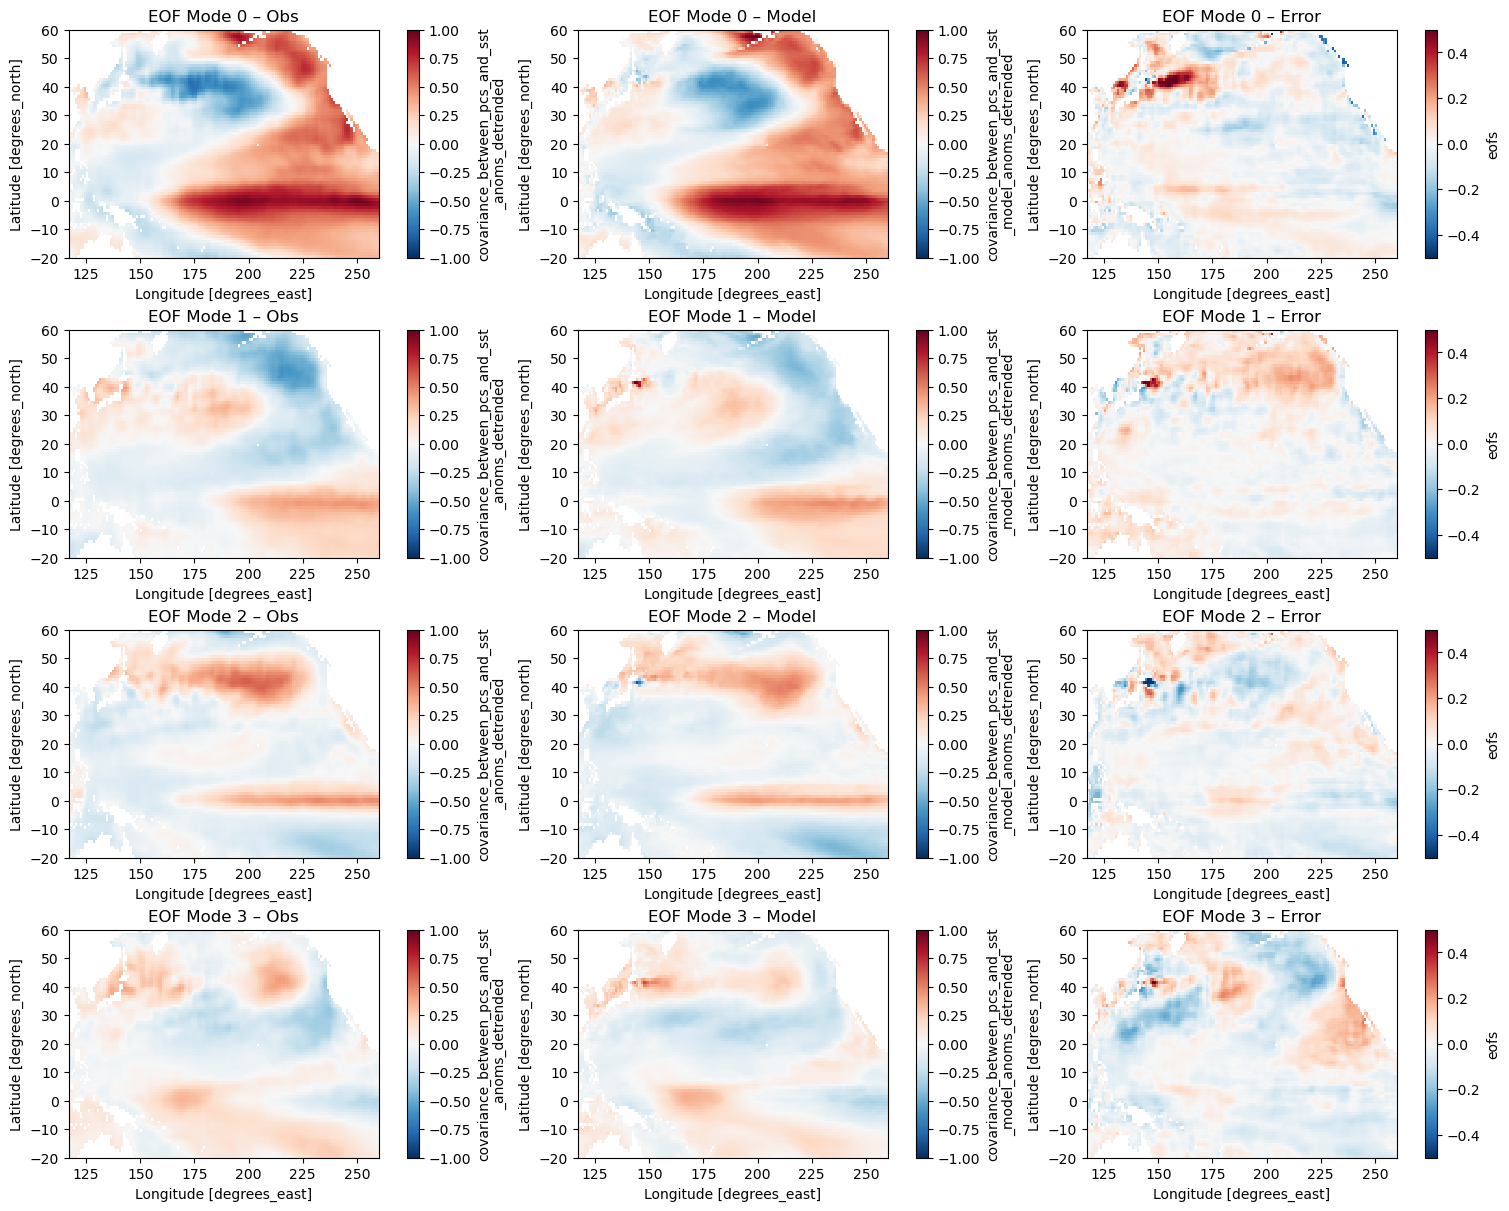

In [10]:
fig_height_per_row = 3  
fig_width = 15

fig, axes = plt.subplots(nrows=NbrPC_plot, ncols=3, figsize=(fig_width, fig_height_per_row * NbrPC_plot), constrained_layout=True)

col_titles = ['Obs', 'Model', 'Error']
datasets = [covmaps_obs, covmaps_model, covmaps_error]
mode_titles = [f'EOF Mode {i}' for i in range(NbrPC_plot)]

for mode in range(NbrPC_plot):  # rows
    for i, data in enumerate(datasets):  # columns
        ax = axes[mode, i]
        cs = data.isel(mode=mode).plot(ax=ax, add_colorbar=True)
        # Adjust color limits
        if i < 2:
            cs.set_clim(-1, 1)
        else:
            cs.set_clim(-0.5, 0.5)
        ax.set_title(f"{mode_titles[mode]} – {col_titles[i]}")

plt.show()

### Principal components

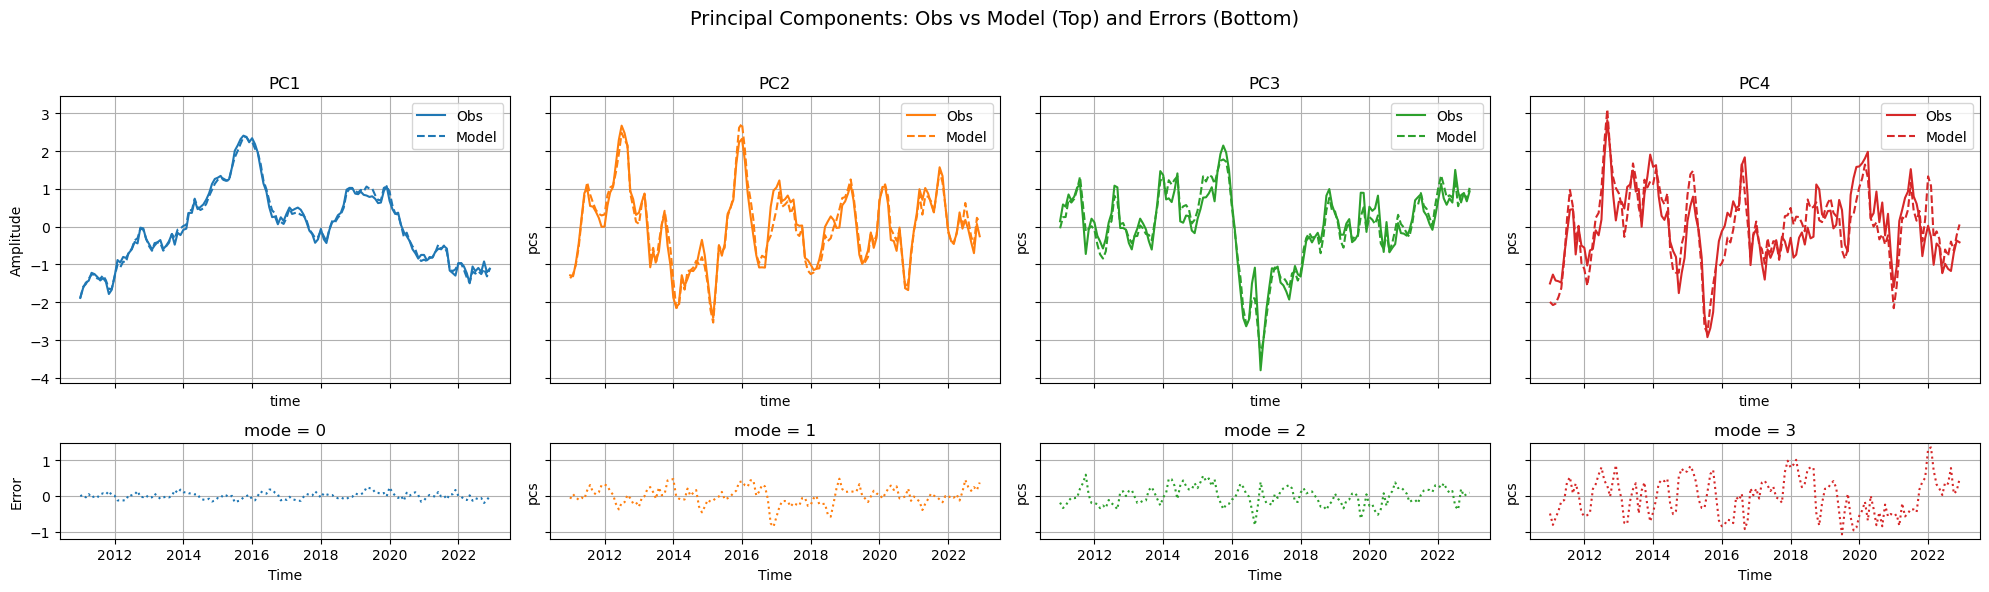

In [11]:
fig, axs = plt.subplots(
    2, NbrPC_plot, figsize=(5 * NbrPC_plot, 6),
    sharex='col', sharey='row',
    gridspec_kw={'height_ratios': [3, 1]}
)

for i in range(NbrPC_plot):
    color = pc_colors[i]

    # Top row: Obs and Model
    ax_top = axs[0, i]
    pcs_obs.sel(mode=i).plot.line(x='time', ax=ax_top, color=color,
                                  linestyle=linestyles['Obs'], label='Obs')
    pcs_model.sel(mode=i).plot.line(x='time', ax=ax_top, color=color,
                                    linestyle=linestyles['Model'], label='Model')
    ax_top.set_title(f'PC{i+1}')
    ax_top.legend()
    ax_top.grid(True)
    if i == 0:
        ax_top.set_ylabel('Amplitude')

    # Bottom row: Error
    ax_bottom = axs[1, i]
    pcs_error.sel(mode=i).plot.line(x='time', ax=ax_bottom, color=color,
                                    linestyle=linestyles['Error'], label='Error')
    ax_bottom.grid(True)
    if i == 0:
        ax_bottom.set_ylabel('Error')
    ax_bottom.set_xlabel('Time')

plt.suptitle('Principal Components: Obs vs Model (Top) and Errors (Bottom)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### PC Correlation

PC1: r = 1.00, p = 2.322e-150
PC2: r = 0.97, p = 3.328e-91
PC3: r = 0.97, p = 1.339e-86
PC4: r = 0.86, p = 1.358e-42


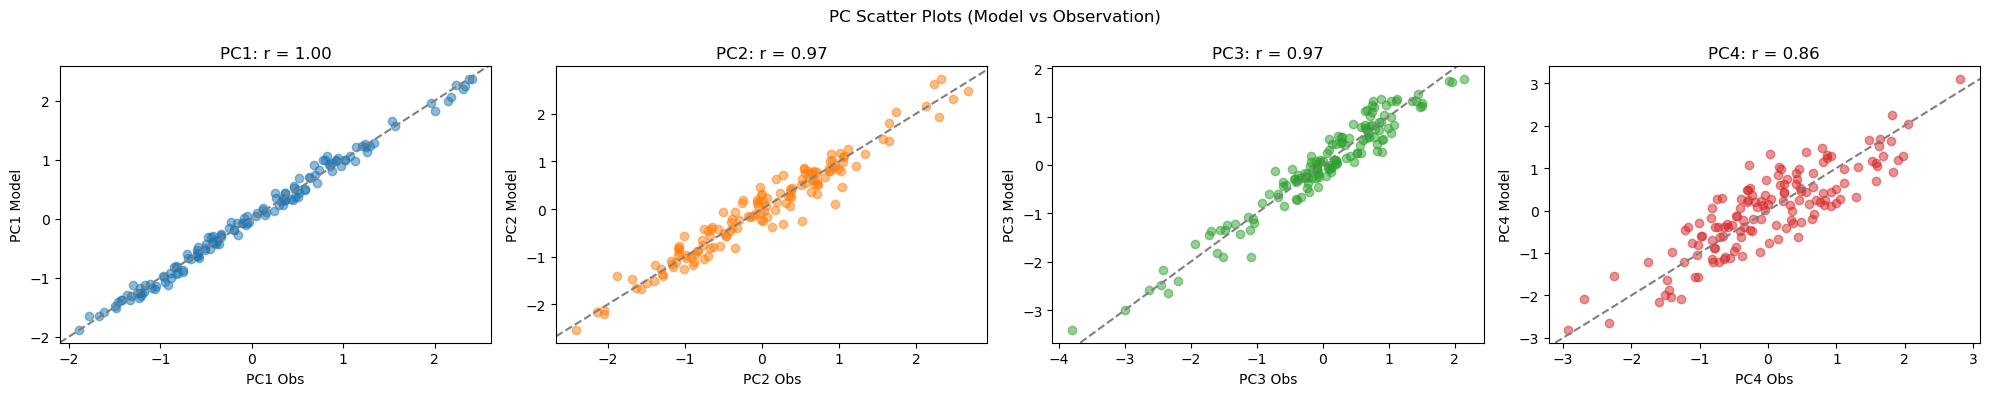

In [12]:
correlations = []
for mode in range(NbrPC):
    obs = pcs_obs.sel(mode=mode).values
    model = pcs_model.sel(mode=mode).values
    r, p = pearsonr(obs, model)
    correlations.append((r, p))

# Scatter plots of PC_model vs PC_obs
fig, axs = plt.subplots(1, NbrPC_plot, figsize=(5 * NbrPC_plot, 4), squeeze=False)

for mode in range(NbrPC_plot):
    obs = pcs_obs.sel(mode=mode).values
    model = pcs_model.sel(mode=mode).values
    ax = axs[0, mode] if NbrPC > 1 else axs
    ax.scatter(obs, model, alpha=0.5, color=pc_colors[mode])
    ax.set_xlabel(f'PC{mode+1} Obs')
    ax.set_ylabel(f'PC{mode+1} Model')
    r, p = correlations[mode]
    print(f"PC{mode+1}: r = {r:.2f}, p = {p:.3e}")
    ax.set_title(f'PC{mode+1}: r = {r:.2f}')
    ax.axline((0, 0), slope=1, color='gray', linestyle='--')

plt.suptitle("PC Scatter Plots (Model vs Observation)")
plt.tight_layout()
plt.show()

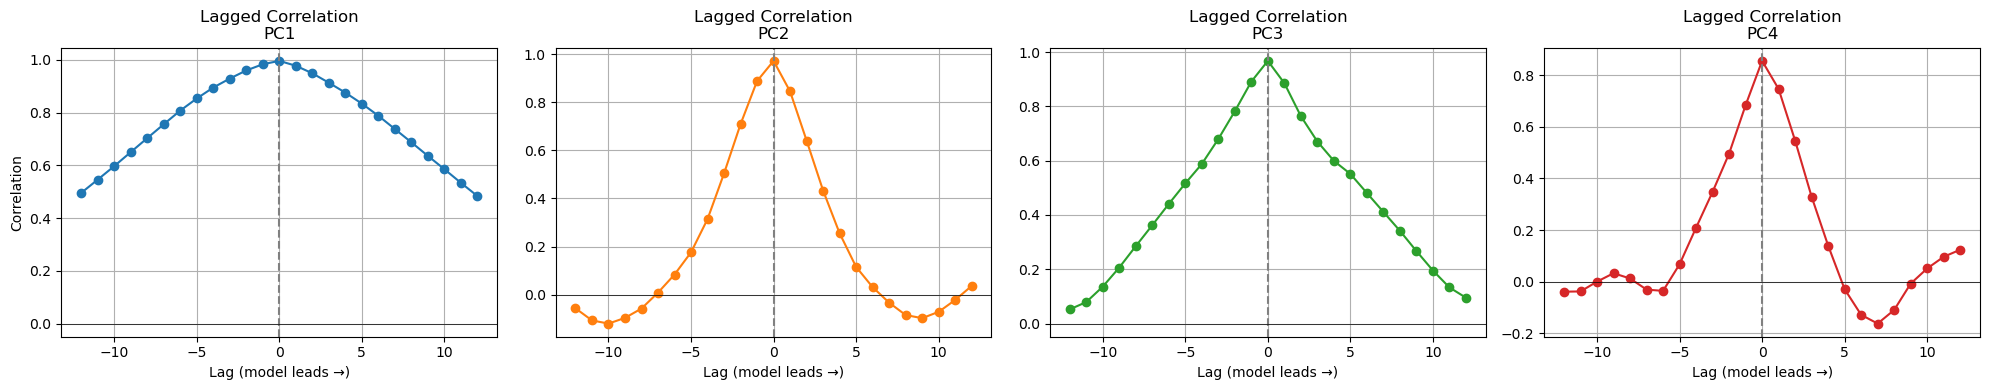

In [13]:
# Lagged correlations
max_lag = 12  # in time steps (months)
lags = np.arange(-max_lag, max_lag + 1)

fig, axs = plt.subplots(1, NbrPC_plot, figsize=(5 * NbrPC_plot, 4), squeeze=False)

for mode in range(NbrPC_plot):
    obs = pcs_obs.sel(mode=mode).values
    model = pcs_model.sel(mode=mode).values
    corr_lagged = []

    for lag in lags:
        if lag < 0:
            r, _ = pearsonr(obs[:lag], model[-lag:])
        elif lag > 0:
            r, _ = pearsonr(obs[lag:], model[:-lag])
        else:
            r, _ = pearsonr(obs, model)
        corr_lagged.append(r)

    ax = axs[0, mode]
    ax.plot(lags, corr_lagged, marker='o', color=pc_colors[mode])
    ax.axvline(0, color='gray', linestyle='--')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(f'Lagged Correlation\nPC{mode+1}')
    ax.set_xlabel('Lag (model leads →)')
    if mode == 0:
        ax.set_ylabel('Correlation')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Error and PC

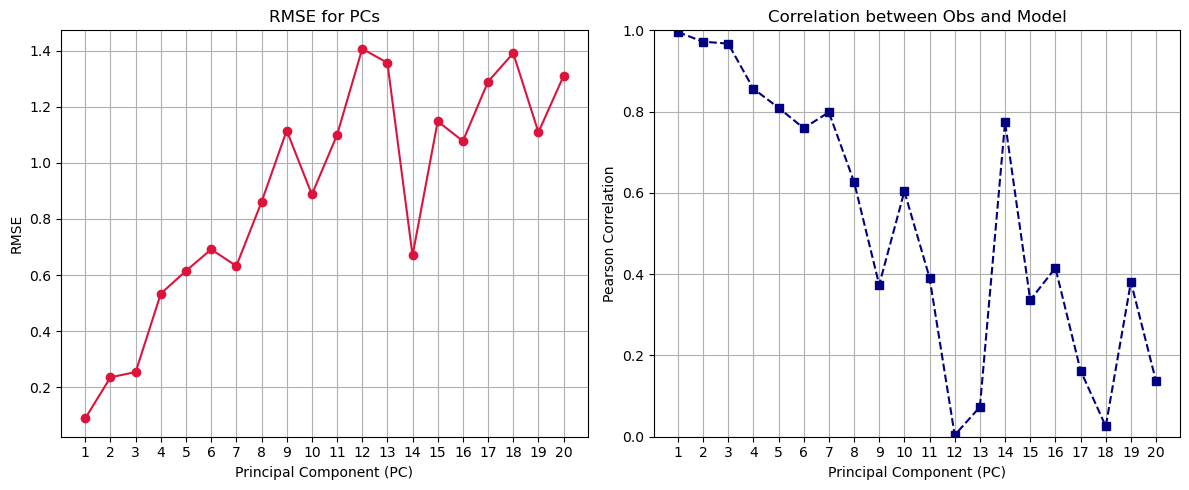

In [14]:
# Calculate RMSE per PC over time (correlations see above)
rmse_per_pc = []
for i in range(NbrPC):
    error = pcs_error.sel(mode=i).values
    rmse = np.sqrt(np.mean(error**2))
    rmse_per_pc.append(rmse)

# PC indices for x-axis
pc_indices = np.arange(1, NbrPC + 1)

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# RMSE plot
ax1.plot(pc_indices, rmse_per_pc, marker='o', color='crimson', linestyle='-')
ax1.set_xlabel('Principal Component (PC)')
ax1.set_xticks(pc_indices)  # set tick locations
ax1.set_xticklabels([str(i) for i in pc_indices])  # then set tick labels
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE for PCs')
ax1.grid(True)

# Correlation plot
correlation_coeffs = [r for r, p in correlations]
ax2.plot(pc_indices, correlation_coeffs, marker='s', color='navy', linestyle='--')
ax2.set_xlabel('Principal Component (PC)')
ax2.set_xticks(pc_indices)  # set tick locations
ax2.set_xticklabels([str(i) for i in pc_indices])
ax2.set_ylabel('Pearson Correlation')
ax2.set_title('Correlation between Obs and Model')
ax2.set_ylim(0, 1)
ax2.grid(True)

plt.tight_layout()
plt.show()

### Spatial correlation

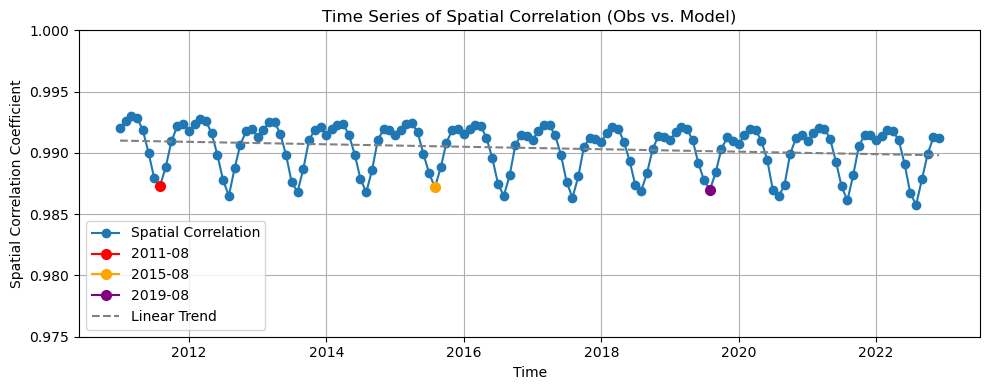

In [15]:
# Flatten SST fields over space (lat, lon)
sst_obs_flat = observations_sst_monthly_2011_2022.stack(space=('lat', 'lon'))
sst_model_flat = nemo00_sst_monthly_2011_2022.stack(space=('lat', 'lon'))

# Pre-allocate array for correlation coefficients (one per time step)
spatial_corr = np.full(observations_sst_monthly_2011_2022.sizes['time'], np.nan)

# Compute correlation at each time step
for t in range(observations_sst_monthly_2011_2022.sizes['time']):
    obs_vec = sst_obs_flat.isel(time=t).values
    model_vec = sst_model_flat.isel(time=t).values

    valid = (~np.isnan(obs_vec)) & (~np.isnan(model_vec))
    if valid.sum() > 0:
        r = np.corrcoef(obs_vec[valid], model_vec[valid])[0, 1]
        spatial_corr[t] = r

# Wrap into DataArray
spatial_corr_da = xr.DataArray(
    spatial_corr,
    coords=[observations_sst_monthly_2011_2022.time],
    dims=["time"],
    name="spatial_correlation"
)

# Prepare data for trend fit
time_nums = mdates.date2num(spatial_corr_da.time.values)  # Convert to float format
valid = ~np.isnan(spatial_corr_da.values)
coeffs = np.polyfit(time_nums[valid], spatial_corr_da.values[valid], deg=1)
trend = np.poly1d(coeffs)(time_nums)

# Highlighted months
highlight_times = [np.datetime64("2011-08"), np.datetime64("2015-08"), np.datetime64("2019-08")]
colors = ['red', 'orange', 'purple']

# Plot
plt.figure(figsize=(10, 4))
plt.plot(spatial_corr_da.time, spatial_corr_da, marker='o', label='Spatial Correlation')

# Highlighted points
for t, c in zip(highlight_times, colors):
    if t in spatial_corr_da.time.values:
        idx = int(np.where(spatial_corr_da.time.values == t)[0][0])
        plt.plot(spatial_corr_da.time[idx], spatial_corr_da[idx],
                 marker='o', color=c, markersize=7, label=f'{str(t)[:10]}')

# Plot trend line
plt.plot(spatial_corr_da.time, trend, color='grey', linestyle='--', linewidth=1.5, label='Linear Trend')

# Final touches
plt.title("Time Series of Spatial Correlation (Obs vs. Model)")
plt.ylabel("Spatial Correlation Coefficient")
plt.xlabel("Time")
plt.grid(True)
plt.ylim(0.975, 1.0)
plt.legend()
plt.tight_layout()
plt.show()